In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [11]:
import os

zip_file_source_path = '/content/drive/MyDrive/edge/number_plate_dataset.zip'

unzipped_dataset_path = './number_plate_dataset_unzipped'

os.makedirs(unzipped_dataset_path, exist_ok=True)

!unzip -o -qq "{zip_file_source_path}" -d "{unzipped_dataset_path}"

print(f"Successfully unzipped '{zip_file_source_path}' to '{unzipped_dataset_path}'")

Successfully unzipped '/content/drive/MyDrive/edge/number_plate_dataset.zip' to './number_plate_dataset_unzipped'


In [12]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm

def load_data(img_dir, xml_dir, target_size=(224, 224)):
    images = []
    labels = []

    img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])

    for img_name in tqdm(img_files):
        img_path = os.path.join(img_dir, img_name)
        image = cv2.imread(img_path)
        h, w, _ = image.shape
        image = cv2.resize(image, target_size) / 255.0

        xml_name = img_name.replace('.png', '.xml')
        xml_path = os.path.join(xml_dir, xml_name)

        if not os.path.exists(xml_path):
            continue

        tree = ET.parse(xml_path)
        root = tree.getroot()

        obj = root.find('object')
        bndbox = obj.find('bndbox')

        xmin = float(bndbox.find('xmin').text) / w
        ymin = float(bndbox.find('ymin').text) / h
        xmax = float(bndbox.find('xmax').text) / w
        ymax = float(bndbox.find('ymax').text) / h

        images.append(image)
        labels.append([xmin, ymin, xmax, ymax])

    return np.array(images), np.array(labels)

IMG_PATH = "./number_plate_dataset_unzipped/images/"
XML_PATH = "./number_plate_dataset_unzipped/annotations/"

X, y = load_data(IMG_PATH, XML_PATH)
print(f"\nLoaded {len(X)} images and labels.")

100%|██████████| 433/433 [00:05<00:00, 72.85it/s]



Loaded 433 images and labels.


In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_basic_lp_detector():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = create_basic_lp_detector()
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16
)

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - loss: 0.0588 - val_loss: 0.0222
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0248 - val_loss: 0.0205
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0259 - val_loss: 0.0156
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0195 - val_loss: 0.0159
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0181 - val_loss: 0.0142
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0142 - val_loss: 0.0135
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0115 - val_loss: 0.0128
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0107 - val_loss: 0.0130
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0099 - val_loss: 0.0134
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0093 - val_loss: 0.0125
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0090 - val_loss: 0.0129
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


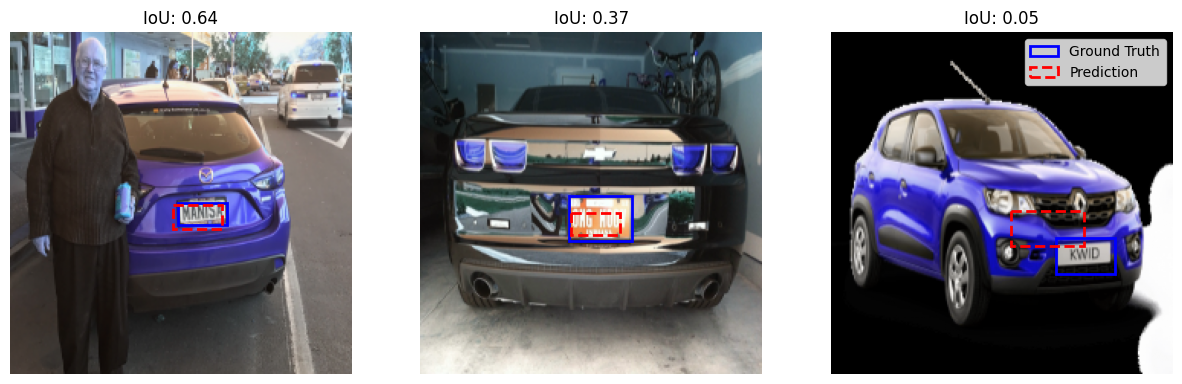

In [14]:
import matplotlib.pyplot as plt

def visualize_results(X_test, y_test, model, num_samples=3):
    plt.figure(figsize=(15, 5))

    indices = np.random.choice(len(X_test), num_samples)

    for i, idx in enumerate(indices):
        img = X_test[idx]
        true_box = y_test[idx]

        pred_box = model.predict(np.expand_dims(img, axis=0))[0]

        score = calculate_iou(pred_box, true_box)

        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)

        h, w, _ = img.shape
        plt.gca().add_patch(plt.Rectangle((true_box[0]*w, true_box[1]*h),
                                          (true_box[2]-true_box[0])*w, (true_box[3]-true_box[1])*h,
                                          edgecolor='blue', fill=False, lw=2, label='Ground Truth'))

        plt.gca().add_patch(plt.Rectangle((pred_box[0]*w, pred_box[1]*h),
                                          (pred_box[2]-pred_box[0])*w, (pred_box[3]-pred_box[1])*h,
                                          edgecolor='red', fill=False, lw=2, linestyle='--', label='Prediction'))

        plt.title(f"IoU: {score:.2f}")
        plt.axis('off')

    plt.legend(loc='upper right')
    plt.show()

visualize_results(X_test, y_test, model)

In [15]:
def calculate_mean_iou(X_test, y_test, model):
    ious = []
    predictions = model.predict(X_test)

    for i in range(len(y_test)):
        score = calculate_iou(predictions[i], y_test[i])
        ious.append(score)

    mean_iou = np.mean(ious)
    accuracy = np.sum(np.array(ious) > 0.5) / len(ious) * 100

    print(f"--- Evaluation Results ---")
    print(f"Mean IoU Score: {mean_iou:.4f}")
    print(f"Detection Accuracy (IoU > 0.5): {accuracy:.2f}%")

    return mean_iou

m_iou = calculate_mean_iou(X_test, y_test, model)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
--- Evaluation Results ---
Mean IoU Score: 0.3197
Detection Accuracy (IoU > 0.5): 33.33%


In [16]:
model_name = 'license_plate_model.h5'
model.save(model_name)

file_size = os.path.getsize(model_name)

print(f"Model File Size: {file_size} bytes")
print(f"Model File Size: {file_size / (1024 * 1024):.2f} MB")

Model File Size: 134081072 bytes
Model File Size: 127.87 MB
